In [1]:
import tensorflow as tf
import numpy as np
import os

# 设置随机种子以确保可重复性
tf.set_random_seed(42)
np.random.seed(42)

# 数据加载部分
def parse_function(image_path, label_path):
    image_string = tf.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image.set_shape([160, 160, 1])

    label_string = tf.read_file(label_path)
    label = tf.image.decode_png(label_string, channels=1)
    label = tf.image.resize_images(label, [20, 20], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.cast(label, tf.int32)
    label.set_shape([20, 20, 1])

    return image, label

def create_dataset(txt_file, batch_size):
    image_paths = []
    label_paths = []
    with open(txt_file, 'r') as f:
        for line in f:
            image_path, label_path = line.strip().split()
            image_paths.append(image_path)
            label_paths.append(label_path)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(parse_function, num_parallel_calls=4)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    return dataset

# 模型定义部分
def build_model(inputs):
    # 加载预训练模型
    with tf.variable_scope('pretrained'):
        # 假设预训练模型的输入为inputs，输出为pretrained_output
        # 这里需要根据您的实际预训练模型代码来替换
        pretrained_output = pretrained_model(inputs)
    
    # 冻结预训练模型的参数
    pretrained_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='pretrained')
    for var in pretrained_variables:
        var.trainable = False

    # 添加新的卷积层
    with tf.variable_scope('new_layers'):
        net = pretrained_output  # 假设尺寸为[batch_size, 20, 20, channels]
        net = tf.layers.conv2d(net, filters=2, kernel_size=3, padding='same', activation=tf.nn.relu)
        net = tf.layers.conv2d(net, filters=2, kernel_size=3, padding='same', activation=tf.nn.relu)
        logits = tf.layers.conv2d(net, filters=34, kernel_size=1, padding='same')  # 输出34个类别的logits

    return logits

def compute_loss(logits, labels):
    labels = tf.squeeze(labels, axis=-1)  # [batch_size, 20, 20]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss = tf.reduce_mean(loss)
    return loss

# 主函数部分
def main():
    batch_size = 8
    learning_rate = 0.001
    num_epochs = 10

    # 创建数据集
    train_dataset = create_dataset('./dataset/train_synt.txt', batch_size)
    val_dataset = create_dataset('./dataset/val_synt.txt', batch_size)

    iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
    images, labels = iterator.get_next()

    train_init_op = iterator.make_initializer(train_dataset)
    val_init_op = iterator.make_initializer(val_dataset)

    # 构建模型
    logits = build_model(images)
    loss = compute_loss(logits, labels)

    # 优化器和训练操作，只更新新添加的层
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='new_layers'))

    # 评估指标
    predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
    labels_flat = tf.squeeze(labels, axis=-1)
    correct_prediction = tf.equal(predictions, labels_flat)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # 混淆矩阵
    confusion_matrix = tf.confusion_matrix(tf.reshape(labels_flat, [-1]), tf.reshape(predictions, [-1]), num_classes=34)

    # 模型保存
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # 训练循环
        for epoch in range(num_epochs):
            sess.run(train_init_op)
            try:
                while True:
                    _, loss_value = sess.run([train_op, loss])
            except tf.errors.OutOfRangeError:
                pass

            # 验证集评估
            sess.run(val_init_op)
            val_loss_list = []
            val_accuracy_list = []
            conf_matrix_total = np.zeros((34, 34), dtype=np.int32)
            try:
                while True:
                    loss_val, acc_val, conf_matrix = sess.run([loss, accuracy, confusion_matrix])
                    val_loss_list.append(loss_val)
                    val_accuracy_list.append(acc_val)
                    conf_matrix_total += conf_matrix
            except tf.errors.OutOfRangeError:
                pass

            avg_val_loss = np.mean(val_loss_list)
            avg_val_accuracy = np.mean(val_accuracy_list)
            print("Epoch: {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch + 1, avg_val_loss, avg_val_accuracy))

        # 保存模型
        saver.save(sess, 'model.ckpt')

        # 计算混淆矩阵并归一化
        conf_matrix_normalized = conf_matrix_total.astype(np.float32) / conf_matrix_total.sum(axis=1, keepdims=True)
        print("Confusion Matrix (Normalized):")
        print(conf_matrix_normalized)

        # 保存混淆矩阵到文件
        np.savetxt('confusion_matrix.csv', conf_matrix_normalized, delimiter=',')

    print("Training completed.")

# 推理代码
def inference(input_image_path):
    with tf.Session() as sess:
        # 加载模型
        saver = tf.train.import_meta_graph('model.ckpt.meta')
        saver.restore(sess, tf.train.latest_checkpoint('./'))

        # 获取需要的tensor
        graph = tf.get_default_graph()
        images_placeholder = graph.get_tensor_by_name("IteratorGetNext:0")
        logits = graph.get_tensor_by_name("new_layers/conv2d_2/BiasAdd:0")  # 根据实际命名修改
        predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)

        # 读取输入图像
        image_string = tf.read_file(input_image_path)
        image = tf.image.decode_png(image_string, channels=1)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image.set_shape([160, 160, 1])
        image = tf.expand_dims(image, axis=0)  # 增加batch维度

        # 运行推理
        pred = sess.run(predictions, feed_dict={images_placeholder: image})
        print("Inference result:")
        print(pred[0])

if __name__ == '__main__':
    main()
    # inference('path_to_test_image.png')


FileNotFoundError: [Errno 2] No such file or directory: 'train_synt.txt'

In [11]:
import tensorflow as tf
import numpy as np
import os

# 设置随机种子以确保可重复性
tf.set_random_seed(42)
np.random.seed(42)

# 数据加载部分
def parse_function(image_path, label_path):
    image_string = tf.read_file(image_path)
    image = tf.image.decode_png(image_string, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image.set_shape([160, 160, 1])

    label_string = tf.read_file(label_path)
    label = tf.image.decode_png(label_string, channels=1)
    label = tf.image.resize_images(label, [20, 20], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.cast(label, tf.int32)
    label.set_shape([20, 20, 1])

    return image, label

def create_dataset(txt_file, batch_size):
    image_paths = []
    label_paths = []
    image_src_path1 = './dataset/real/160x160/gray'
    image_src_path2 = './dataset/transfer/Cable1_019_0_19/gray'
    label_src_path = './dataset/instruction-complete'
    with open(txt_file, 'r') as f:
        for line in f:
            if os.path.exists(os.path.join(image_src_path1, line.strip()+'.jpg')):
                image_path = os.path.join(image_src_path1, line.strip()+'.jpg')
            else:
                image_path = os.path.join(image_src_path2, line.strip()+'.jpg')
            label_path = os.path.join(label_src_path, line.strip()+'.png')
            image_paths.append(image_path)
            label_paths.append(label_path)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(parse_function, num_parallel_calls=4)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    return dataset

In [12]:
train_dataset = create_dataset('./dataset/train_synt.txt', 8)
val_dataset = create_dataset('./dataset/val_synt.txt', 8)

In [13]:
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
images, labels = iterator.get_next()

train_init_op = iterator.make_initializer(train_dataset)
val_init_op = iterator.make_initializer(val_dataset)

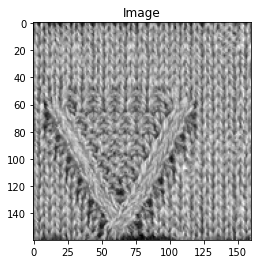

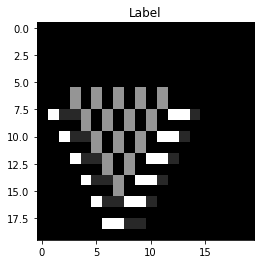

In [14]:
import matplotlib.pyplot as plt

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(train_init_op)  # 修改此处

    # 运行一次以获取一批数据
    images_batch, labels_batch = sess.run([images, labels])

    # 显示第一张图片和标签
    plt.imshow(images_batch[0].reshape(160, 160), cmap='gray')
    plt.title("Image")
    plt.show()

    plt.imshow(labels_batch[0].reshape(20, 20), cmap='gray')
    plt.title("Label")
    plt.show()


In [1]:
from util import Loader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

In /home/holic/miniconda3/envs/tf1.11/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/holic/miniconda3/envs/tf1.11/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/holic/miniconda3/envs/tf1.11/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [5]:
loader = Loader('./dataset', 2, 2, {'use_rend':1, 'use_tran': 0, 'augment': 0, 'match_mode': 3}, xfer=True)

Using rend from ./dataset/rendering


In [6]:
loader.datasets

{'train': <PrefetchDataset shapes: {synt: (<unknown>, <unknown>), real: (<unknown>, <unknown>)}, types: {synt: (tf.float32, tf.int32), real: (tf.float32, tf.int32)}>,
 'val': <PrefetchDataset shapes: {synt: (<unknown>, <unknown>), real: (<unknown>, <unknown>)}, types: {synt: (tf.float32, tf.int32), real: (tf.float32, tf.int32)}>,
 'test': <PrefetchDataset shapes: {real: (<unknown>, <unknown>, <unknown>)}, types: {real: (tf.float32, tf.int32, tf.string)}>}

In [7]:
# 配置 TensorFlow 会话
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
# config.log_device_placement = True

sess = tf.Session(config=config)

# 创建训练集迭代器
train_iter = loader.iter(set_option='train')

# 获取迭代器句柄
train_handle = sess.run(train_iter.string_handle())

# 创建迭代器切换的占位符和通用迭代器
batch_handle = tf.placeholder(tf.string, shape=[])
batch_iter = tf.data.Iterator.from_string_handle(batch_handle, train_iter.output_types, train_iter.output_shapes)

# 获取当前批次的数据
curbatch = batch_iter.get_next()

# 初始化所有全局和局部变量（特别是迭代器）
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [8]:
# 运行会话并获取 curbatch 的值
curbatch_value = sess.run(curbatch, feed_dict={batch_handle: train_handle})

In [11]:
palette = np.array([
    [255, 0, 16],       # FK
    [30, 206, 30],      # BK
    [255, 255, 128],    # T
    [0, 255, 127],      # H|M
    [130, 210, 210],    # M
    [34, 139, 34],      # E|V(L)
    [0, 191, 255],      # V|HM
    [0, 129, 69],       # V(R)
    [255, 0, 190],      # V(L)
    [255, 164, 4],      # X(R)
    [0, 117, 220],      # X(L)
    [117, 59, 59],      # S
    [179, 179, 179],    # T(F)
    [255, 215, 0],      # V|M
    [255, 105, 180],    # T(B)
    [160, 32, 240],     # M|H(B)
    [139, 69, 19],      # E|V(R)
    [0, 164, 255],      # V|FK
    [255, 30, 30],      # FK, MAK
    [230, 230, 110],    # FT, FKMAK
    [220, 200, 100],    # FT, MBK
    [100, 230, 230],    # M, BK
    [110, 220, 220],    # M, FK
    [20, 200, 255],     # V, BK
    [10, 140, 80],      # VR, FKMAK
    [10, 250, 110],     # H, BK
    [240, 20, 170],     # VL, FKMAK
    [240, 100, 30],     # AO(2)
    [250, 110, 40],     # O(5), AK
    [200, 100, 70],     # O(5), FKBK
    [220, 80, 60],      # BO(2)
    [230, 90, 50],      # O(5), BK
    [130, 10, 120],     # Y, MATBK
    [170, 10, 90]       # FO(2)
])

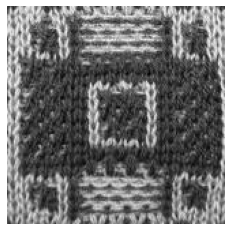

In [9]:
array = curbatch_value['real'][0]
array = array[0, :, :, 0]

rend = (array - array.min()) / (array.max() - array.min()) * 255
rend = rend.astype(np.uint8)

plt.imshow(rend, cmap='gray')
plt.axis('off')  # 隐藏坐标轴
plt.show()

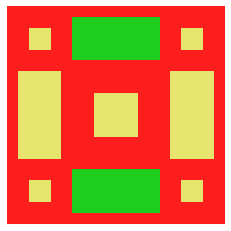

In [12]:
array = curbatch_value['synt'][1]
array = array[0, :, :, 0]

inst_synt = palette[array]
plt.imshow(inst_synt)
plt.axis('off')  # 隐藏坐标轴
plt.show()